In [85]:
# ========== 🔧 Setup ==========
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.1-8b-instant", temperature=0)

# ========== 🛠️ Tools ==========
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily = TavilySearchResults(max_results=5, search_depth="advanced", max_tokens=10000)

@tool
def tv_search(query: Annotated[str, "The web search query string."]) -> str:
    """Search the web for up-to-date information using Tavily."""
    try:
        results = tavily.invoke(query)
        if isinstance(results, list):
            formatted = "\n".join(
                [f"{i+1}. {res.get('title', '')}: {res.get('content', '')}" for i, res in enumerate(results)]
            )
            return f"### 🔍 Top search results for: **{query}**\n\n{formatted}"
        return f"No results found for: {query}"
    except Exception as e:
        return f"Search failed: {repr(e)}"

repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "Python code to execute."]) -> str:
    """Executes Python code and returns stdout. Use `print()` to display output."""
    try:
        result = repl.run(code)
        return f"""### ✅ Executed Python Code:\n```python\n{code}\n```\n### 🖨️ Output:\n```\n{result}\n```"""
    except Exception as e:
        return f"""### ❌ Execution failed:\n```python\n{code}\n```\n### ⚠️ Error:\n```\n{repr(e)}\n```"""

# ========== 🧠 Agent State ==========
import operator
from typing import Sequence, TypedDict, Literal
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: Literal["Researcher", "chart_generator"]

# ========== 🤖 Agents ==========
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    llm,
    tools=[tv_search],
    state_modifier="""You are a helpful AI assistant, collaborating with other assistants.
                        Use the provided tools to progress towards answering the question.
                        If you are unable to fully answer, that's OK,
                        another assistant with different tools will help where you left off.
                        Execute what you can to make progress.
                        If you or any of the other assistants have the final answer or deliverable,
                        prefix your response with FINAL ANSWER so the team knows to stop.

                         Use `tv_search` when needed. 
                         You should provide accurate data for the chart_generator to use."""
)

chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier="""You are a Python chart generator assistant. Use `python_repl_tool` to execute Python code.
    After plotting, always conclude your message with 'FINAL ANSWER'"""
)

# ========== 🧩 Agent Nodes ==========
from langchain_core.messages import ToolMessage, AIMessage

def research_agent_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    if isinstance(result, ToolMessage):
        return {"messages": [result], "sender": "Researcher"}
    if isinstance(result, AIMessage):
        return {"messages": [result], "sender": "Researcher"}
    return {"messages": [AIMessage(content=str(result), name="Researcher")], "sender": "Researcher"}

def chart_agent_node(state: AgentState) -> AgentState:
    result = chart_agent.invoke(state)
    if isinstance(result, ToolMessage):
        return {"messages": [result], "sender": "chart_generator"}
    if isinstance(result, AIMessage):
        return {"messages": [result], "sender": "chart_generator"}
    return {"messages": [AIMessage(content=str(result), name="chart_generator")], "sender": "chart_generator"}

# ========== 🛠️ ToolNode ==========
from langgraph.prebuilt import ToolNode

tools = [tv_search, python_repl_tool]
tool_node = ToolNode(tools)

# ========== 🚦 Router ==========
def router(state: AgentState) -> Literal["call_tool", "continue", "__end__"]:
    last_msg = state["messages"][-1]
    print("🔀 Router input:", last_msg.content)
    if getattr(last_msg, "tool_calls", None):
        return "call_tool"
    if "FINAL ANSWER" in last_msg.content:
        return "__end__"
    return "continue"

# ========== 🌐 LangGraph Workflow ==========
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)
graph.add_node("Researcher", research_agent_node)
graph.add_node("chart_generator", chart_agent_node)
graph.add_node("call_tool", tool_node)

graph.add_conditional_edges("Researcher", router, {
    "call_tool": "call_tool",
    "continue": "chart_generator",
    "__end__": END,
})

graph.add_conditional_edges("chart_generator", router, {
    "call_tool": "call_tool",
    "continue": "Researcher",
    "__end__": END,
})

graph.add_conditional_edges("call_tool", lambda state: state["sender"], {
    "Researcher": "Researcher",
    "chart_generator": "chart_generator"
})

graph.set_entry_point("Researcher")
agent = graph.compile()




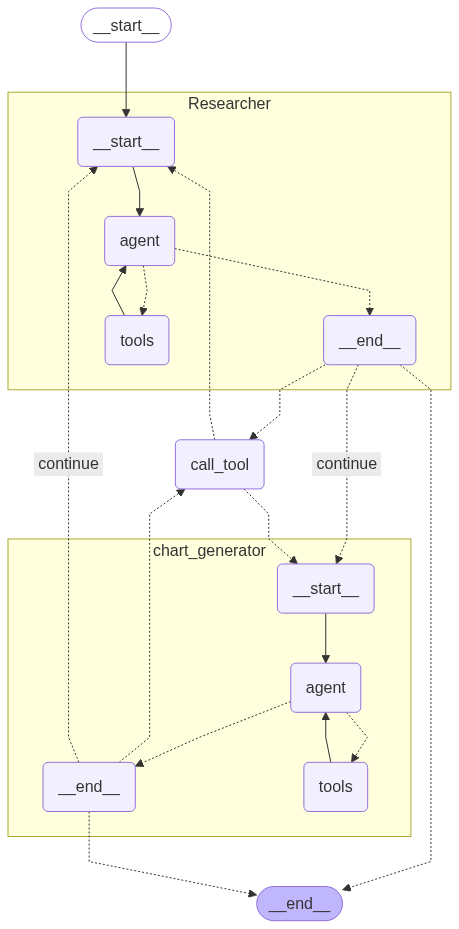

In [86]:
from IPython.display import display, Image, Markdown


try:
    display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

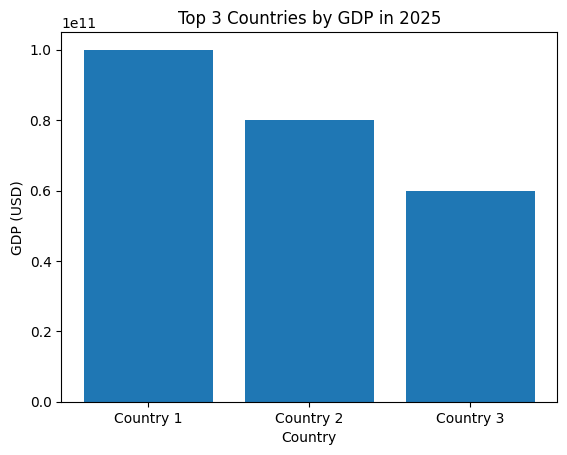

In [11]:
# ========== ▶️ Run Example ==========
from langchain_core.messages import HumanMessage

input_state = {
    "messages": [HumanMessage(content="Find the top 3 countries by GDP and plot a bar chart in 2025")],
    "sender": "Researcher"
}

final_state = agent.invoke(input_state)

# ========== 🖨️ Show Final Result ==========
print("\n\n### ✅ Final Agent Output:\n")
print(final_state["messages"][-1].content)


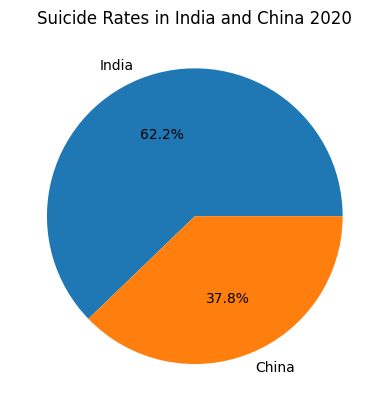

In [70]:
# ========== ▶️ Run Example ==========
from langchain_core.messages import HumanMessage

input_state = {
    "messages": [HumanMessage(content="Find total suicide rates in India and China in 2020 and plot pie chart")],
    "sender": "Researcher"
}

final_state = agent.invoke(input_state)

# ========== 🖨️ Show Final Result ==========
print("\n\n### ✅ Final Agent Output:\n")
print(final_state["messages"][-1].content)
